this tutorial is taken from: https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb

In [15]:
import stim

# Creating a surface code circuit and detecting errors

Let's generate the circuit without errors:

In [444]:
circuit = stim.Circuit.generated('surface_code:rotated_memory_z',
                                distance=3,
                                rounds=2,
                            )
print(repr(circuit))

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1

Plot the qubits and their role in the circuit

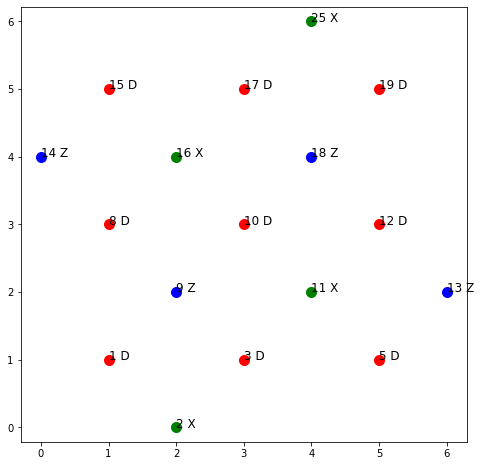

In [152]:
import matplotlib.pyplot as plt

coords = []
qnums = []
for st in repr(circuit).splitlines():
    st = st.strip()
    if st[0] == "Q":
        coord = st[st.find('(')+1:st.find(')')]
        coord = [int(s) for s in coord.split(',')]
        qnums.append(int(st.split(' ')[-1]))
#        print(coord)
        coords.append(coord)
coords = np.array(coords)
qnums = np.array(qnums)

plt.figure(figsize=(8, 8))
for qnum, coord in zip(qnums, coords):
    if coord[0] % 2 == 1:
        color = 'r'
        txt = 'D'
    elif sum(coord) % 4 == 2:
        color = 'g'
        txt = 'X'
    elif sum(coord) % 4 == 0:
        color = 'b'
        txt = 'Z'

    plt.plot(coord[0], coord[1], 'o'+color, markersize=10);
    plt.text(coord[0], coord[1], ' '.join((str(qnum), txt)), size='large');
plt.axis('equal');

We read off manually for now the z matching matrix. Here we create a 4 x 7 matrix since we data qubits 1, 3 and 17, 19. We do this because the ancillas can't distinguish between errors on them, and a the logical Z operator is only sensitive to their parity anyway

[[0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1]
 [1 0 0 1 1 0 0]
 [0 0 0 0 1 1 0]]


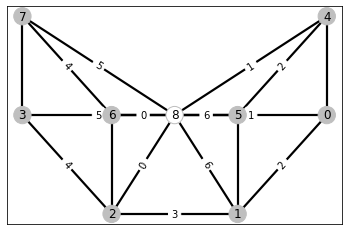

In [445]:
match_z_col_index = [17, 15, 8, 10, 12, 5, 3]
match_z_row_index = [14, 9, 18, 13]
logical_z_qubits = [1, 3, 5]

match_z = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 1, 0, 0]
]).T
import pymatching

print(match_z.astype(int))
mm = pymatching.Matching(H=match_z.astype(int), repetitions=2)
mm.draw()

Manually inject an error on all qubits and check if they can be corrected

In [461]:
circuit_err = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    
    X_ERROR(1) 1
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK

    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4] 
    DETECTOR(2, 2, 0) rec[-7] 
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5] 

    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] 
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] 
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] 
    DETECTOR(6, 2, 1) rec[-4] rec[-7]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

sampler = circuit_err.compile_detector_sampler()

def get_detection_events_and_logical_state(circuit):
    """
    only works for one shot now
    """
    sampler = circuit.compile_detector_sampler()
    meas_res = sampler.sample(shots=1, append_observables=True)[0]
    
    logical_state = meas_res[-1]
    
    # get all relevant detector outcomes
    first_round = meas_res[:4]
    mid_rounds = meas_res[4:-9].reshape(-1, 8)[[4, 1, 6, 3]]  # these indices correspond to z_ancillas in the sequence 2 9 11 13 14 16 18 25 measured in the code
    last_round = meas_res[-9:-1].reshape(-1, 4)
    detector_outcomes = np.r_[first_round, mid_rounds, last_round]

print(f"uncorrected logical state = {logical_state}")
des = np.diff(detector_outcomes, axis=0) % 2  # detection events
print("detection events")
print(des.astype(int))

# decode the X errors

def logical_state_correction(detection_events: np.array, matching_object: pymatching.Matching):
    decoded = matching_object.decode(detection_events.T)
    print(decoded)
    errors = [match_z_col_index[k] for k in decoded.nonzero()[0]]
    print(f'error is in {errors}')
    z_index = [match_z_col_index.index(k) for k in logical_z_qubits if k in match_z_col_index]
    logical_errors = np.sum(decoded[z_index]) % 2
    return logical_errors

    
corrected_logical_state = (logical_state + logical_state_correction(des, mm)) % 2
print(f'corrected logical state = {corrected_logical_state.astype(int)}')

uncorrected logical state = 1
detection events
[[0 1 0 0]
 [0 0 0 0]]
[0 0 0 0 0 0 1]
error is in [3]
corrected logical state = 0


# Errors with increasing number of rounds

Now let's use a variable number of rounds and correct, see what is the probability of a successful correction

In [ ]:
num_rounds = 2

circ_rounds = stim.Circuit.generated('surface_code:rotated_memory_z',
                                distance=3,
                                rounds=num_rounds,
                            )

mm_rounds = pymatching.Matching(match_z, repetitions=num_rounds)


In [462]:
des

array([[0, 1, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [463]:
np.r_[des, des]

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [464]:
meas_res

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]], dtype=uint8)

In [466]:
meas_res[:, :4]

array([[0, 0, 0, 0]], dtype=uint8)

In [470]:
meas_res[:, 4:-9]

array([], shape=(1, 0), dtype=uint8)

In [475]:
np.arange(21)[4:-9].reshape(-1, 4)

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [489]:
rr = np.arange(13)
np.vstack([rr[np.newaxis,:4], rr[np.newaxis, 4:-9], rr[-9:-1].reshape(-1, 4)])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 0

In [482]:
np.newaxis

Type:        NoneType
String form: None
Docstring:   <no docstring>


In [490]:
rr[-9:-1].reshape(-1, 4).

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [488]:
rr[np.newaxis, 4:-9]

array([], shape=(1, 0), dtype=int64)

In [494]:
circuit.detector_error_model(decompose_errors=True)

stim.DetectorErrorModel('''
    detector(0, 4, 0) D0
    detector(2, 2, 0) D1
    detector(4, 4, 0) D2
    detector(6, 2, 0) D3
    shift_detectors(0, 0, 1) 0
    detector(2, 0, 0) D4
    detector(2, 2, 0) D5
    detector(4, 2, 0) D6
    detector(6, 2, 0) D7
    detector(0, 4, 0) D8
    detector(2, 4, 0) D9
    detector(4, 4, 0) D10
    detector(4, 6, 0) D11
    detector(0, 4, 1) D12
    detector(2, 2, 1) D13
    detector(4, 4, 1) D14
    detector(6, 2, 1) D15
    logical_observable L0
''')

In [496]:
##########################################################
#################### BEGIN GLUE CODE #####################
##########################################################

import math
import networkx as nx
import pymatching
from typing import Callable, List


def predict_observable_errors_using_pymatching(circuit: stim.Circuit,
                                               det_samples: np.ndarray,
                                               ) -> np.ndarray:
    """Turn detection events into predicted observable errors."""
    error_model = circuit.detector_error_model(decompose_errors=True)
    matching_graph = detector_error_model_to_pymatching_graph(error_model)

    num_shots = det_samples.shape[0]
    num_obs = circuit.num_observables
    num_dets = circuit.num_detectors
    assert det_samples.shape[1] == num_dets

    predictions = np.zeros(shape=(num_shots, num_obs), dtype=np.bool8)
    for k in range(num_shots):
        expanded_det = np.resize(det_samples[k], num_dets + 1)
        expanded_det[-1] = 0
        predictions[k] = matching_graph.decode(expanded_det)
    return predictions


def detector_error_model_to_pymatching_graph(model: stim.DetectorErrorModel) -> pymatching.Matching:
    """Convert a stim error model into a pymatching graph."""
    g = detector_error_model_to_nx_graph(model)
    num_detectors = model.num_detectors
    num_observables = model.num_observables

    # Add spandrels to the graph to ensure pymatching will accept it.
    # - Make sure there's only one connected component.
    # - Make sure no detector nodes are skipped.
    # - Make sure no observable nodes are skipped.
    for k in range(num_detectors):
        g.add_node(k)
    g.add_node(num_detectors + 1)
    for k in range(num_detectors + 1):
        g.add_edge(k, num_detectors + 1, weight=9999999999)
    g.add_edge(num_detectors, num_detectors + 1, weight=9999999999, qubit_id=list(range(num_observables)))

    mm = pymatching.Matching(g)
    mm.draw()
    return pymatching.Matching(g)


def detector_error_model_to_nx_graph(model: stim.DetectorErrorModel) -> nx.Graph:
    """Convert a stim error model into a NetworkX graph."""

    g = nx.Graph()
    boundary_node = model.num_detectors
    g.add_node(boundary_node, is_boundary=True, coords=[-1, -1, -1])

    def handle_error(p: float, dets: List[int], frame_changes: List[int]):
        if p == 0:
            return
        if len(dets) == 0:
            # No symptoms for this error.
            # Code probably has distance 1.
            # Accept it and keep going, though of course decoding will probably perform terribly.
            return
        if len(dets) == 1:
            dets = [dets[0], boundary_node]
        if len(dets) > 2:
            raise NotImplementedError(
                f"Error with more than 2 symptoms can't become an edge or boundary edge: {dets!r}.")
        if g.has_edge(*dets):
            edge_data = g.get_edge_data(*dets)
            old_p = edge_data["error_probability"]
            old_frame_changes = edge_data["qubit_id"]
            # If frame changes differ, the code has distance 2; just keep whichever was first.
            if set(old_frame_changes) == set(frame_changes):
                p = p * (1 - old_p) + old_p * (1 - p)
                g.remove_edge(*dets)
        g.add_edge(*dets, weight=math.log((1 - p) / p), qubit_id=frame_changes, error_probability=p)

    def handle_detector_coords(detector: int, coords: np.ndarray):
        g.add_node(detector, coords=coords)

    eval_model(model, handle_error, handle_detector_coords)

    return g


def eval_model(
        model: stim.DetectorErrorModel,
        handle_error: Callable[[float, List[int], List[int]], None],
        handle_detector_coords: Callable[[int, np.ndarray], None]):
    """Interprets the error model instructions, taking care of loops and shifts.

    Makes callbacks as error mechanisms are declared, and also when detector
    coordinate data is declared.
    """
    det_offset = 0
    coords_offset = np.zeros(100, dtype=np.float64)

    def _helper(m: stim.DetectorErrorModel, reps: int):
        nonlocal det_offset
        nonlocal coords_offset
        for _ in range(reps):
            for instruction in m:
                if isinstance(instruction, stim.DemRepeatBlock):
                    _helper(instruction.body_copy(), instruction.repeat_count)
                elif isinstance(instruction, stim.DemInstruction):
                    if instruction.type == "error":
                        dets: List[int] = []
                        frames: List[int] = []
                        t: stim.DemTarget
                        p = instruction.args_copy()[0]
                        for t in instruction.targets_copy():
                            if t.is_relative_detector_id():
                                dets.append(t.val + det_offset)
                            elif t.is_logical_observable_id():
                                frames.append(t.val)
                            elif t.is_separator():
                                # Treat each component of a decomposed error as an independent error.
                                # (Ideally we could configure some sort of correlated analysis; oh well.)
                                handle_error(p, dets, frames)
                                frames = []
                                dets = []
                        # Handle last component.
                        handle_error(p, dets, frames)
                    elif instruction.type == "shift_detectors":
                        det_offset += instruction.targets_copy()[0]
                        a = np.array(instruction.args_copy())
                        coords_offset[:len(a)] += a
                    elif instruction.type == "detector":
                        a = np.array(instruction.args_copy())
                        for t in instruction.targets_copy():
                            handle_detector_coords(t.val + det_offset, a + coords_offset[:len(a)])
                    elif instruction.type == "logical_observable":
                        pass
                    else:
                        raise NotImplementedError()
                else:
                    raise NotImplementedError()
    _helper(model, 1)

##########################################################
##################### END GLUE CODE ######################
##########################################################

<pymatching.Matching object with 17 detectors, 1 boundary node, and 17 edges>

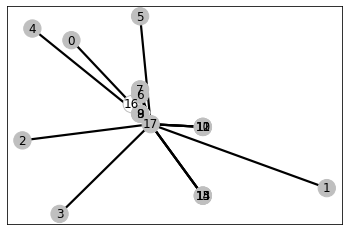

In [498]:
detector_error_model_to_pymatching_graph(circuit.detector_error_model(decompose_errors=True))

detector(0, 1, 0) D0
detector(0, 3, 0) D1
detector(2, 1, 0) D2
detector(2, 3, 0) D3
detector(4, 1, 0) D4
detector(4, 3, 0) D5
shift_detectors(0, 0, 1) 0
detector(1, 0, 0) D6
detector(3, 0, 0) D7
detector(0, 1, 0) D8
detector(2, 1, 0) D9
detector(4, 1, 0) D10
detector(1, 2, 0) D11
detector(3, 2, 0) D12
detector(0, 3, 0) D13
detector(2, 3, 0) D14
detector(4, 3, 0) D15
detector(1, 4, 0) D16
detector(3, 4, 0) D17
detector(0, 1, 1) D18
detector(0, 3, 1) D19
detector(2, 1, 1) D20
detector(2, 3, 1) D21
detector(4, 1, 1) D22
detector(4, 3, 1) D23
logical_observable L0


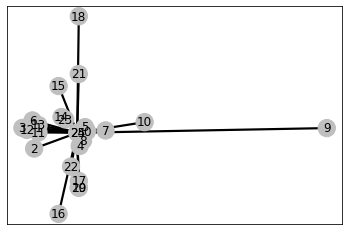

In [510]:
noise = 0
circuit = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=2,
    distance=3,
    after_clifford_depolarization=noise,
    after_reset_flip_probability=noise,
    before_measure_flip_probability=noise,
    before_round_data_depolarization=noise)
print(circuit.detector_error_model(decompose_errors=True))
mo = detector_error_model_to_pymatching_graph(circuit.detector_error_model(decompose_errors=True))

In [554]:
expanded_det[:-1].reshape(-1, 2).T

array([[0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [567]:
from pprint import pprint

In [757]:
reps = 1
repc = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=reps,
    distance=3)
print(repr(repc))
repc = stim.Circuit('''
    R 0 1 2 3 4
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    X_ERROR(0.5) 0 2

    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

stim.Circuit('''
    R 0 1 2 3 4
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')


observable =  0
[[0 0]
 [0 1]]
mo decode [0]


array([0, 0, 1], dtype=uint8)

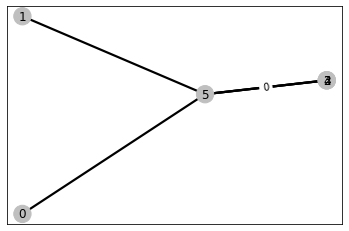

In [756]:
mo = detector_error_model_to_pymatching_graph(repc.detector_error_model(decompose_errors=True))
# measurements = repc.compile_sampler().sample(1)

# def convert(measurements):
#     data_outcomes = 
# shots = converter.convert(measurements, append_observable=True)
shots = repc.compile_detector_sampler().sample(1, append_observables=True)[0]
# print(repc.compile_sampler().sample(1)[0])
observable = shots[-1]
print('observable = ', observable)
expanded_det = np.resize(shots[:-1], repc.num_detectors + 1)
print(expanded_det[:-1].reshape(-1, 2))
expanded_det[-1] = 0
print('mo decode', mo.decode(expanded_det))
mo2 = pymatching.Matching([[1, 1, 0], [0, 1, 1]], repetitions=reps+1)


mo2.decode(expanded_det[:-1].reshape(-1, 2).T)

<pymatching.Matching object with 6 detectors, 1 boundary node, and 13 edges>


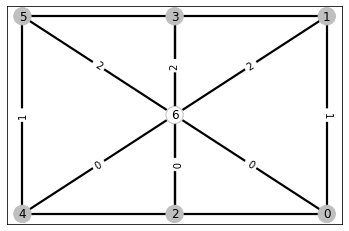

In [534]:
mo2 = pymatching.Matching([[1, 1, 0], [0, 1, 1]], repetitions=3)
print(mo2)
mo2.draw()

array([[False]])

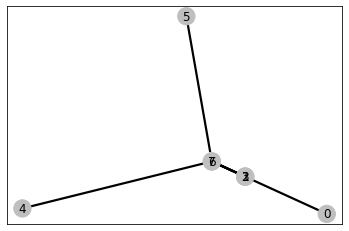

In [539]:
predict_observable_errors_using_pymatching(repc, repc.compile_detector_sampler().sample(1))

In [540]:
repc.num_detectors

6

In [541]:
expanded_det = np.resize(repc.compile_detector_sampler().sample(1), repc.num_detectors + 1)
expanded_det[-1] = 0

In [542]:
expanded_det

array([0, 0, 0, 0, 0, 0, 0], dtype=uint8)